**Machine Learning Development life cycle**  
1. Task  
2. Data Preparation  
3. Modelling
4. Error Measurement
5. Training and Optimization
6. Performance Measurement
7. Validating and Testing
8. Corrective Measures

Using Python 3.8.18

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, InputLayer, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.legacy import Adam

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

**Data Preparation**

![Dataset split](Dataset_Split.png "Dataset split")  
The split of this dataset is only "Train", so we can't have "Test"

In [2]:
dataset, dataset_info = tfds.load("malaria", with_info = True, shuffle_files=True, as_supervised=True, split=["train"])

2024-01-29 00:42:57.443960: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-01-29 00:42:57.443980: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-01-29 00:42:57.443985: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-01-29 00:42:57.444012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-29 00:42:57.444025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/Users/cheesemac/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin bl

In [5]:
for data in dataset[0].take(5):
    print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [6]:
print(len(dataset[0]))

27558


Now we define a `splits()` function to split our dataset into train, validation and test sets with given ratios, using `take()` and `skip()`

In [7]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))

    val_dataset = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))
    val_dataset = val_dataset.take(int(DATASET_SIZE*VAL_RATIO))

    test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO + VAL_RATIO)))

    return train_dataset, val_dataset, test_dataset

Looking at the picture about the splits of this dataset, we should note that this dataset is of type `list`, in order to access the data, we have to go to index `0`, so `dataset[0]`

In [8]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 1 - (TRAIN_RATIO + VAL_RATIO)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2755
2756


In [9]:
print(list(train_dataset.take(5).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

In [10]:
for data in train_dataset.take(16):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(106, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

**Dataset Visualization**

In [11]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/Users/cheesemac/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin bl

Looking at `"label"`, we can see that it is of `ClassLabel()` feature, with `num_classes = 2` meaning that it contains 2 classes. Labels are stored as integers in the dataset. When you retrieve the labels, `ClassLabel.int2str()` and `ClassLabel.str2int()` carries out the conversion from integer value to label name, and vice versa.  

There is also `Value()` feature.

*Referenced from:* https://huggingface.co/docs/datasets/about_dataset_features

Using `plt.subplot`

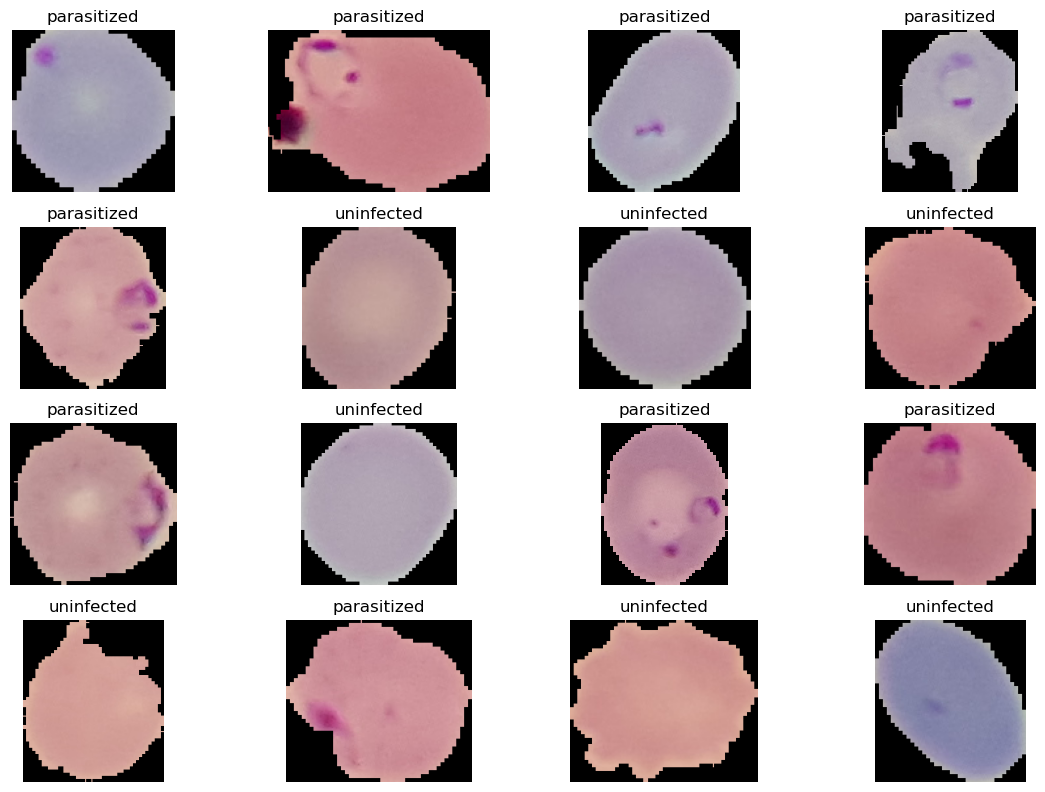

In [12]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(train_dataset.take(16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

plt.tight_layout(pad=1)

**Data Processing**

When do we use stadardization, and when normalization?  
* We use standardization when the data in our dataset lie mainly around a mean with standard deviation.
* We use normalization when the data in our dataset are mainly different and is distributed fairly randomly within a range (min, max)

That explains why normalization is a better suit for this dataset, since the values lie between 0 and 255 and are faily random. In this case, our normalization formula is going to be `(x - x_min)/(x_max - x_min) = x / 255`

First, we need to resize our images to have an uniform size

We will use `map()` attribute to apply a resizing function to our dataset. But since this attribute only return our image and not our label, which is also needed to assign to our dataset, we will first define a resizing function

In [13]:
IMG_SIZE = 224
def resize_normalize(img, label):
    return tf.image.resize(img, [IMG_SIZE, IMG_SIZE]) / 255, label

In [14]:
train_dataset = train_dataset.map(resize_normalize)

In [15]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


The data type of `resize_normalize(img, label)[0]` is kind of like a list or an array, that's why we can broadcast like `tf.image.resize(img, [IMG_SIZE, IMG_SIZE]) / 255` in the function `resize_normalize`

In [16]:
for img, label in train_dataset.take(1):
    print(list(resize_normalize(img, label)[0]))

[<tf.Tensor: shape=(224, 3), dtype=float32, numpy=
array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
    

In [17]:
train_dataset = train_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

**Convolutional Neural Network (CNN)**  
For better visualization: https://poloclub.github.io/cnn-explainer/  
Note for padding: When using padding, we have to ensure that the outer layers (especially the corners) still have impact on the data

Padding is especially useful when the actual image is located somewhere in the outer layer. When padding, the cursor with given kernel size will go through the image more times.  

`output = (input + 2 * Padding - Kernel)/Stride + 1`


***How CNN works:***  

 ![CNN Visualization](CNN.png "CNN Visualization")  

 With the kernel, padding and stride specified, the kernel will now parse through the input of all dimensions, multiply by a *filter* and take the sum of all the results to be the output value at the corresponding position.  

 The filter is a matrix of the same size with the kernel. There are pre-existing filters like outline, sharpen or blur etc.  
 
 ![Outline filter](Filter.png "Outline filter")  
 Visual source: https://setosa.io/ev/image-kernels/
 
 But in CNN, we don't specify the filter. We just initialize the initial filter matrix, and let the model decide for themselves.  

***LeNet and AlexNet***  

![LeNet and AlexNet](AlexNet_Lenet.png "LeNet and AlexNet")  
Visual source: https://en.wikipedia.org/wiki/AlexNet  

Explanation on how to get outputs:  
![Output](Output.png "Output")  

If the image has size 64x64x3 (RGB), when applied to a filter 5x5 like in the illustration shown above, will have an output of shape AxAx1, in order to get something like AxAx6, we have to have 6 filters, and then stack the output on each other (into ***channels***).  

Moreover, for each filter, after multiplying the input to the filter, we have to add the bias. In total, we would have 6 biases.  

Parameters to be trained: **(3 x 5 x 5) x 6 + 6 = 456** parameters to be trained

**Pooling Layers**  

Pooling layer summarises the features present in regions of the output map generated by the CNN, and reduces the dimension of the input to the next layer  

To reduce the dimension to a half, we pick the size of filter (kernel) to be 2, and stride 2, because then `output = (input - kernel) / stride + 1 = (input - 2) / 2 + 1 = input / 2`

In [18]:
model = Sequential([
    InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 5, padding = "valid", activation = "sigmoid"),
    MaxPool2D(pool_size = 2, strides=2),

    Conv2D(filters = 16, kernel_size = 5, padding = "valid", activation = "sigmoid"),
    MaxPool2D(pool_size = 2, strides=2),

    Flatten(),

    Dense(100, activation = "sigmoid"),
    Dense(10, activation = "sigmoid"),
    Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 44944)             0         
                                                                 
 dense (Dense)               (None, 100)               4

In [19]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(from_logits=False))

In [20]:
sess = tf.compat.v1.Session(config=config)
process = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

Epoch 1/100


2024-01-29 00:42:59.243797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-29 00:42:59.243810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-29 00:42:59.411208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


689/689 [==============================] - ETA: 0s - loss: 7.7077

2024-01-29 00:43:19.157421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-29 00:43:20.013648: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17629113459463514201
2024-01-29 00:43:20.013670: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4548618063157113922


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/c1/frv2q9z92mn9r_np8s6v84cm0000gn/T/ipykernel_53396/1084426562.py", line 2, in <module>
      process = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1791, in fit
      val_logs = self.evaluate(
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1955, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/c1/frv2q9z92mn9r_np8s6v84cm0000gn/T/ipykernel_53396/1084426562.py", line 2, in <module>
      process = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1791, in fit
      val_logs = self.evaluate(
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1955, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [127,148,3] and element 6 had shape [94,100,3].
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [127,148,3] and element 6 had shape [94,100,3].
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_4270]